In [40]:
import numpy as np
import pandas as pd
from IPython.display import Image

from rdkit.Chem import AllChem

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.manifold import TSNE
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the data

In [2]:
# https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html
df = pd.read_csv('data/titanic.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace the missing values with nan
df.replace("?", np.nan, inplace = True)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Explore

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1046 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1308 non-null   object
 9   cabin      295 non-null    object
 10  embarked   1307 non-null   object
 11  boat       486 non-null    object
 12  body       121 non-null    object
 13  home.dest  745 non-null    object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


In [5]:
age = pd.to_numeric(df.age, errors='coerce')
df['age'] = age
fare = pd.to_numeric(df.fare, errors='coerce')
df['fare'] = fare
df.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing

body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
ticket          0
parch           0
sibsp           0
sex             0
name            0
survived        0
pclass          0
dtype: int64

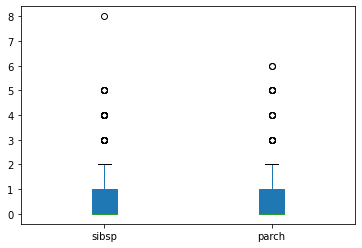

In [44]:
plot = df[['sibsp', 'parch']].boxplot(patch_artist=True, grid=False)

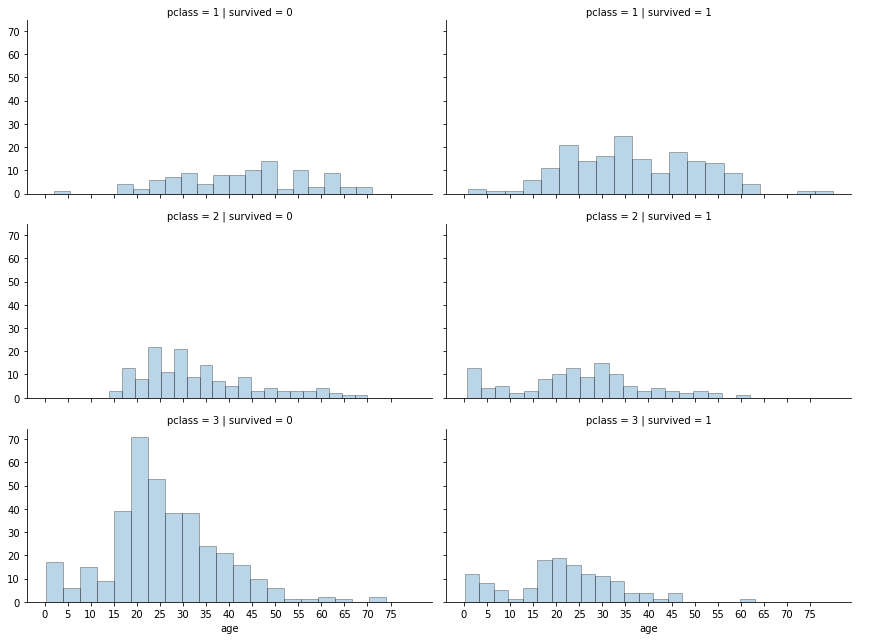

In [8]:
plot = sns.FacetGrid(df, col='survived', row='pclass', height=3, aspect=2)
plot.map(plt.hist, 'age', bins=20, alpha=.3, edgecolor='black')
plot.set(xticks=np.arange(0,80,5))
plot.add_legend()

In [9]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [10]:
# drop some columns and the rows with missing values
# beware of throwing the data out mindlessly, it can change the probabilities in the columns
keep = ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare']
df = df[keep]
df = df.dropna()
df.shape

(1045, 7)

In [11]:
# lets add some columns based on the existing data
df['gender'] = pd.get_dummies(df.sex, drop_first=True)
df = df.drop(['sex'], axis=1)
df

,pclass,survived,age,sibsp,parch,fare,gender
0,1,1,29.0000,0,0,211.3375,0
1,1,1,0.9167,1,2,151.5500,1
2,1,0,2.0000,1,2,151.5500,0
3,1,0,30.0000,1,2,151.5500,1
4,1,0,25.0000,1,2,151.5500,0
...,...,...,...,...,...,...,...
1301,3,0,45.5000,0,0,7.2250,1
1304,3,0,14.5000,1,0,14.4542,0
1306,3,0,26.5000,0,0,7.2250,1
1307,3,0,27.0000,0,0,7.2250,1


In [12]:
# lets add category if the passenger was child
df['kid'] = pd.cut(x=df['age'], bins=[0, 15, 100], labels=[1, 0]) 

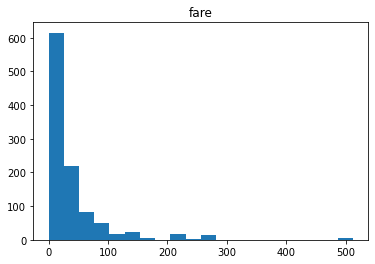

In [13]:
# lets check fare so we know how to bin this column into categories
# basicaly we can say, there were cheaper tickets and pretty expensive ones
plot = df.hist('fare', bins=20, grid=False)

In [14]:
# We still have fare and age, both as floats; lets categorize them
df['age_cats'] = pd.cut(x=df['age'], bins=[0, 15, 25, 35, 45, 55, 65, 100], labels=np.arange(1,8))
df['fare_cats'] = pd.cut(x=df['fare'], bins=[-1, 25, 50, 100, 200, 1000], labels=np.arange(1,6))

In [15]:
# and drop the old columns
df = df.drop(['fare', 'age'], axis=1)

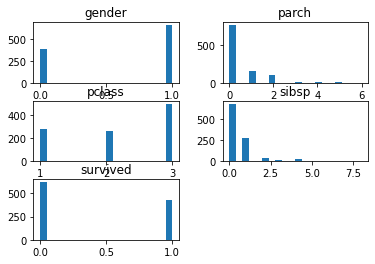

In [16]:
plot = df.hist(bins=20, grid=False)

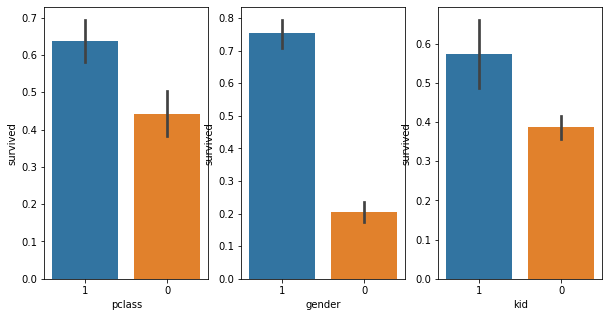

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10,5))
plot1 = sns.barplot(df['pclass'], df['survived'], ax=axes[0])
plot2 = sns.barplot(df['gender'], df['survived'], ax=axes[1])
plot3 = sns.barplot(df['kid'], df['survived'], ax=axes[2])

In [18]:
df

,pclass,survived,sibsp,parch,gender,kid,age_cats,fare_cats
0,1,1,0,0,0,0,3,5
1,1,1,1,2,1,1,1,4
2,1,0,1,2,0,1,1,4
3,1,0,1,2,1,0,3,4
4,1,0,1,2,0,0,2,4
...,...,...,...,...,...,...,...,...
1301,3,0,0,0,1,0,5,1
1304,3,0,1,0,0,1,1,1
1306,3,0,0,0,1,0,3,1
1307,3,0,0,0,1,0,3,1


In [19]:
missing = df.isna().sum().sort_values(ascending=False)
missing

fare_cats    0
age_cats     0
kid          0
gender       0
parch        0
sibsp        0
survived     0
pclass       0
dtype: int64

In [20]:
df.fare_cats.value_counts()

1    614
2    218
3    134
4     43
5     36
Name: fare_cats, dtype: int64

# Preprocessing

In [21]:
from sklearn.model_selection import train_test_split

y = np.array(df.survived).ravel()
x = np.array(df[['pclass', 'age_cats', 'sibsp', 'parch', 'gender', 'kid', 'fare_cats']])


X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

# MODELS

In [22]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression Classifier

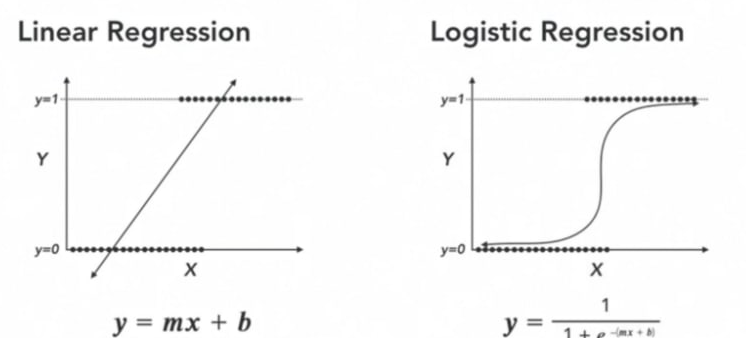

In [41]:
Image(filename='d:\\_PHD\ML_ensembles\\ML_ensembles\\figures\\log_reg.png') 

In [25]:
# first - lets declare the model and it's hyperparameters
model = LogisticRegression(random_state=0, max_iter=5000)

# second - fit it with our data (find the model parameters)
model.fit(X_train, y_train)

# third - test the model
logreg_c_score = score_and_report(model, X_test, y_test)

# Precision is the metrics that tell how many passengers we predicted to survive correctly
# The recall tells how many people in percents we predicted to survive out of those who actualy survived
# The F-score is computed with the harmonic mean of precision and recall

crossval score:  0.8317126269956457 AUC:  0.8276630770286029
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       140
           1       0.84      0.80      0.82       122

    accuracy                           0.84       262
   macro avg       0.84      0.83      0.83       262
weighted avg       0.84      0.84      0.84       262



In [ ]:
![precision, recall](https://i1.wp.com/interviewbubble.com/wp-content/uploads/2019/03/1pOtBHai4jFd-ujaNXPilRg.png?resize=936%2C340&ssl=1)

# false positives, true positives
# https://learncuriously.wordpress.com/2018/10/21/confused-by-the-confusion-matrix/
![confusion matrix](https://learncuriously.files.wordpress.com/2018/10/confusion-matrix-cell-labels1.png?w=500&h=500)

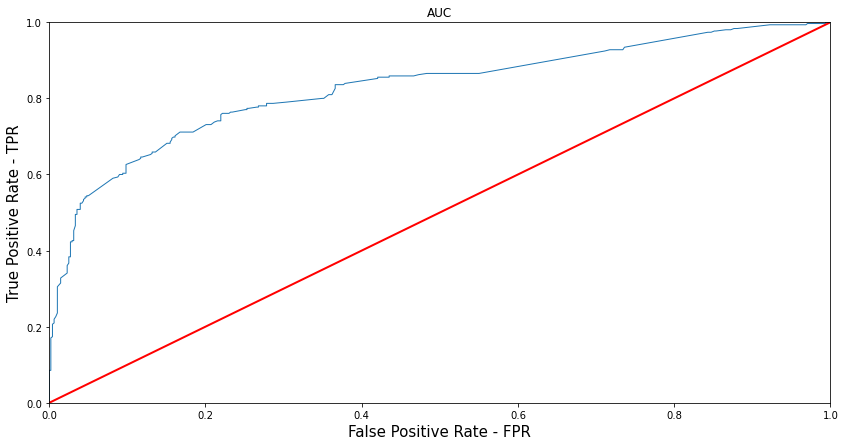

AUC:  0.8276630770286029


In [26]:
# getting the probabilities of our predictions
y_scores = model.predict_proba(X_train)
y_scores = y_scores[:,1]

# compute true positive rate and false positive rate
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.figure(figsize=(14, 7))
plot_roc_curve(fpr, tpr)
plt.show()
print('AUC: ', metrics.auc(fpr, tpr))

In [27]:
model = SGDClassifier(max_iter=50, tol=None, loss="modified_huber").fit(X_train, y_train)

sgd_c_score = score_and_report(model, X_test, y_test)

crossval score:  0.7674891146589259 AUC:  0.664939296248028
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       140
           1       0.88      0.42      0.57       122

    accuracy                           0.70       262
   macro avg       0.77      0.68      0.67       262
weighted avg       0.76      0.70      0.68       262



# Decision Tree

In [29]:
model = DecisionTreeClassifier().fit(X_train, y_train)

dectree_c_score = score_and_report(model, X_test, y_test)

crossval score:  0.7820029027576197 AUC:  0.91970642705261
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       140
           1       0.85      0.70      0.77       122

    accuracy                           0.81       262
   macro avg       0.81      0.80      0.80       262
weighted avg       0.81      0.81      0.80       262



# Random Forest Classifier

In [31]:
model = RandomForestClassifier(n_estimators=200, max_depth=3).fit(X_train, y_train)

rf_c_score = score_and_report(model, X_test, y_test)

crossval score:  0.816400580551524 AUC:  0.8385143013924138
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       140
           1       0.91      0.69      0.79       122

    accuracy                           0.82       262
   macro avg       0.84      0.82      0.82       262
weighted avg       0.84      0.82      0.82       262



In [32]:
importances = pd.DataFrame({'feature':['pclass', 'age_cats', 'sibsp', 'parch', 'gender', 'kid', 'fare_cats'],
                            'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
gender,0.503
pclass,0.173
fare_cats,0.133
parch,0.059
age_cats,0.051
sibsp,0.042
kid,0.040


# MLP Classifier

In [34]:
model = MLPClassifier(random_state=0, max_iter=500).fit(X_train, y_train)

mlp_c_score = score_and_report(model, X_test, y_test)

crossval score:  0.828011611030479 AUC:  0.8680636531998079
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       140
           1       0.87      0.70      0.78       122

    accuracy                           0.81       262
   macro avg       0.82      0.81      0.81       262
weighted avg       0.82      0.81      0.81       262



In [35]:
mlp_c_score

(0.828011611030479, 0.8680636531998079)

# All results

In [37]:
index_names = ['logreg', 'sgd', 'dectree', 'rf', 'mlp']
results = pd.DataFrame([logreg_c_score, sgd_c_score, dectree_c_score, rf_c_score, mlp_c_score], 
                       columns=['accuracy', 'auc'],
                       index=index_names)
results

,accuracy,auc
logreg,0.831713,0.827663
sgd,0.767489,0.664939
dectree,0.782003,0.919706
rf,0.816401,0.838514
mlp,0.828012,0.868064


In [24]:
# helper functions

from sklearn.metrics import roc_curve

# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=2)
    plt.axis([0, 1, 0, 1])
    plt.title('AUC')
    plt.xlabel('False Positive Rate - FPR', fontsize=15)
    plt.ylabel('True Positive Rate - TPR', fontsize=15)

# scoring function, report and AUC    
def score_and_report(model, X_test, y_test):
    y_scores = model.predict_proba(X_train)
    y_scores = y_scores[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    auc = metrics.auc(fpr, tpr)    
    
    y_pred = model.predict(X_test)
    score = np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy'))
    
    print('crossval score: ', score, 'AUC: ', auc)
    print(classification_report(y_test, y_pred))
    
    return score, auc
    